In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

# Anomaly Detection

In [2]:
data = loadmat("data/ex8data1.mat") # dict.keys() = [Xval, X, yval]

In [3]:
X = data['X']
Xval = data['Xval']
yval = data['yval']

## Plot Data

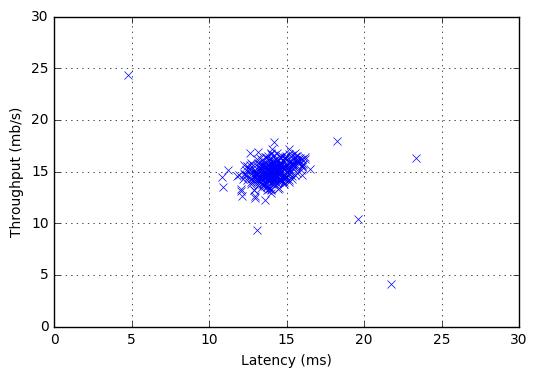

In [4]:
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.axis([0, 30, 0, 30])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.grid('on')
plt.show()

In [5]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    var = np.var(X, axis=0)
    
    return mu, var

In [6]:
def multivariateGaussian(X, mu, var):
    k = mu.shape[0]
    X = X - mu
    
    if len(var.shape) == 1:
        var = np.diag(var)
    p = (2 * np.pi) ** (-k / 2) * np.linalg.det(var) ** (-0.5) * np.exp(-1/2 * np.sum(X.dot(np.linalg.inv(var))* X, axis=1))
    
    return p

In [7]:
def selectThreshold(yval, pval):
    """
    Find the best epsilon to select outliers

    Returns
    ========
    epsilon
    F1 score
    """
    best_eps = 0
    best_F1 = 0
    F1 = 0
    yval = yval.flatten()
    for eps in np.linspace(np.min(pval), np.max(pval), 1000):
        
        predictions = (pval < eps)
        
        TP = np.sum((predictions == 1) & (yval == 1))
        FP = np.sum((predictions == 1) & (yval == 0))
        FN = np.sum((predictions == 0) & (yval == 1))
        
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
                
        F1 = 2 * precision * recall / (precision + recall + 1e-10)       
        
        if F1 > best_F1:
            best_F1 = F1
            best_eps = eps
            
    return best_eps, best_F1

In [8]:
mu, var = estimateGaussian(X)
p = multivariateGaussian(X, mu, var)
pval = multivariateGaussian(Xval, mu, var)
best_eps, F1 = selectThreshold(yval, pval)

print("Best Epsilon: {}".format(best_eps))
print("Best F1 Score: {}".format(F1))

Best Epsilon: 8.999852631901395e-05
Best F1 Score: 0.8749999999398437


In [9]:
outliers = p < best_eps

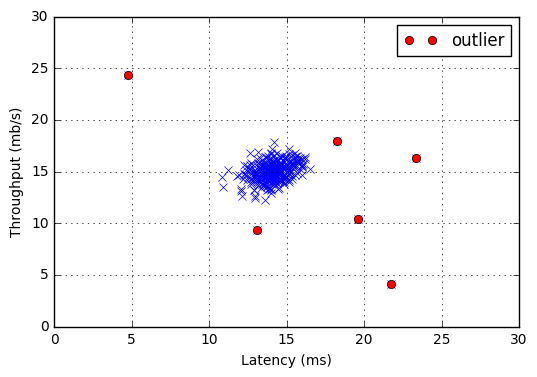

In [10]:
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.axis([0, 30, 0, 30])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', label='outlier')
plt.legend()
plt.grid('on')
plt.show()

## Multidimensional Outliers

In [11]:
data = loadmat("data/ex8data2.mat")
Xval = data['Xval']
X = data['X']
yval = data['yval']

In [12]:
mu, var = estimateGaussian(X)
p = multivariateGaussian(X, mu, var)
pval = multivariateGaussian(Xval, mu, var)
best_eps, F1 = selectThreshold(yval, pval)

In [13]:
print("Best eps: {}".format(best_eps))
print("Best F1: {}".format(F1))
print("Outliers Found: {}".format(np.sum(p < best_eps)))

Best eps: 1.3786074982000245e-18
Best F1: 0.6153846153325445
Outliers Found: 117


# Recommender System

In [14]:
data = loadmat("data/ex8_movies.mat")
Y = data['Y'] # 1682 x 943 matrix: rating (1-5) of 1682 movies on 943 users
R = data['R'] # R(i, j) == 1 if user j gives a rating to movie i (= Y == 0)

## Average Rating for Movie 0 (Toy Story)

In [15]:
np.mean(Y[0, :][R[0] == 1]) # Average Rating for Toy Story is 3.88

3.8783185840707963

## Visualize the Movie Rating

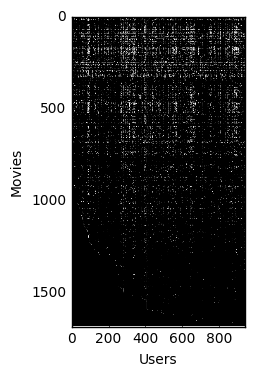

In [16]:
plt.imshow(Y, cmap='gray')
plt.ylabel("Movies")
plt.xlabel("Users")
plt.show()

## Load Pre-defined Movie Data

- X: (movies,features)
- Theta: (users, features)

In [17]:
data = loadmat("data/ex8_movieParams.mat")
X = data['X']
Theta = data['Theta']

In [18]:
num_users = 4
num_movies = 5
num_features = 3

X_small = X[0:num_movies, 0:num_features]
Theta_small = Theta[0:num_users, 0:num_features]
Y_small = Y[0:num_movies, 0:num_users]
R_small = R[0:num_movies, 0:num_users]

In [19]:
def cofiCostFunction(X_Theta, Y, R, num_users, num_movies, num_features, reg):
    """Calculate Cost Function for the Collaborative Filtering
    
    Returns
    ==========
    J (float): cost
    grad (dict): vectors
    """
    
    X = X_Theta[0:num_movies * num_features]
    Theta = X_Theta[num_movies * num_features:]
    
    X = X.reshape(num_movies, -1)
    Theta = Theta.reshape(num_users, -1)
    
    grad = dict()
    J = 0.0
    
    loss = X.dot(Theta.T) * R - Y * R    
    J = np.sum(np.square(loss)) / 2
    
    grad['X'] = loss.dot(Theta)
    grad['Theta'] = loss.T.dot(X)
    
    # Regularization
    J += reg / 2 * (np.sum(np.square(X)) + np.sum(np.square(Theta)))
    grad['X'] += reg * X
    grad['Theta'] += reg * Theta
    
    
    grad = np.append(grad['X'].flatten(), grad['Theta'].flatten())
    return J, grad

In [20]:
X_Theta = np.append(X_small.flatten(), Theta_small.flatten())
J, grad = cofiCostFunction(X_Theta, Y_small, R_small, num_users, num_movies, num_features, 0)
print("{} should be close to 22.22".format(J))

J, grad = cofiCostFunction(X_Theta, Y_small, R_small, num_users, num_movies, num_features, 1.5)
print("{} should be close to 31.34".format(J))

22.224603725685675 should be close to 22.22
31.34405624427422 should be close to 31.34


## Gradient Check (Nuemric Gradient Descent vs Analytic Gradient Descent)

In [21]:
def eval_numerical_grad(X):
    cost_function = lambda x: cofiCostFunction(x, Y_small, R_small, num_users, num_movies, num_features, 0)
    
    grad_numeric_X = np.zeros_like(X)
    for i in range(len(X)):
        h = 1e-8
        old_X = X.copy()
        old_X[i] -= h
        new_X = X.copy()

        new_X[i] += h
        
        J_new, _ = cost_function(new_X)
        J_old, _ = cost_function(old_X)
        
        grad_numeric = (J_new - J_old) / (2 * h)
        grad_numeric_X[i] = grad_numeric
    
    J, grad = cost_function(X)
    grad_analytic = grad
        
    rel_error = np.sqrt(np.sum(np.square(grad_numeric_X - grad_analytic)))       

    print("err: {}".format(rel_error))

## Main Step to Run Gradient Descent
- it uses the Adam optimizer

In [22]:
def run_sgd(X_Theta, Y, R, num_users, num_movies, num_features, learning_rate=0.01, max_iter = 100, reg = 0, verbose=False):
    J_history = []
    
    beta1 = 0.99
    beta2 = 0.999
    eps = 1e-8
    m, v = 0, 0
    
    for i in range(max_iter):
        J, grad = cofiCostFunction(X_Theta, Y, R, num_users, num_movies, num_features, reg)
        m = beta1 * m  + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        
        m_hat = m / ( 1- beta1**(i+1))
        v_hat = v / ( 1 - beta2**(i+1))
        
        X_Theta -= learning_rate * m_hat / (np.sqrt(v_hat) + eps)
        if verbose:
            print("Loss: {}".format(J))
            
        J_history.append(J)
    
    print("Final Loss: {}".format(J_history[-1]))
    return J_history, X_Theta

In [23]:
J_hist, best_X_Theta = run_sgd(X_Theta, Y_small, R_small, num_users, num_movies, num_features, verbose=False)

Final Loss: 3.052125075890447


In [24]:
import pandas as pd
import re
getter = re.compile(r"(\d+)\s(.+)") # Data File Format: [1 Toy Story(1997), (\d+)\s(.+), ...]

In [25]:
def open_movie_idx(filepath):
    result = dict()
    with open(filepath, encoding='ISO-8859-1') as f:
        data = f.readlines()
        data = [x.strip() for x in data]
        
        for line in data:
            match = getter.match(line)
            id = match.groups()[0]
            title = match.groups()[1]

            result[int(id) - 1] = title

    return result
        

def search_movie(movie_idx, title):
    for k, v in movie_idx.items():
        if title.lower() in v.lower():
            yield k, v

In [26]:
movie_idx = open_movie_idx("data/movie_ids.txt")

## Search Movies by Titles

In [27]:
for k, v in search_movie(movie_idx, "Silence"):
    print("{}: {}".format(k, v))

97: Silence of the Lambs, The (1991)
1629: Silence of the Palace, The (Saimt el Qusur) (1994)


## My Rating for Movies

In [28]:
my_ratings = np.zeros(shape=(1682, 1))

my_ratings[0] = 4;
my_ratings[97] = 2;
my_ratings[6] = 3;
my_ratings[11] = 5;
my_ratings[53] = 4;
my_ratings[63] = 5;
my_ratings[65] = 3;
my_ratings[68] = 5;
my_ratings[182] = 4;
my_ratings[225] = 5;
my_ratings[354] = 5;

In [29]:
for i, val in enumerate(my_ratings):
    if val > 0:
        print("Rated {} for the movie of {}".format(val[0], movie_idx[i]))

Rated 4.0 for the movie of Toy Story (1995)
Rated 3.0 for the movie of Twelve Monkeys (1995)
Rated 5.0 for the movie of Usual Suspects, The (1995)
Rated 4.0 for the movie of Outbreak (1995)
Rated 5.0 for the movie of Shawshank Redemption, The (1994)
Rated 3.0 for the movie of While You Were Sleeping (1995)
Rated 5.0 for the movie of Forrest Gump (1994)
Rated 2.0 for the movie of Silence of the Lambs, The (1991)
Rated 4.0 for the movie of Alien (1979)
Rated 5.0 for the movie of Die Hard 2 (1990)
Rated 5.0 for the movie of Sphere (1998)


## Processing Data with my movie rating

In [30]:
Y_new = np.concatenate((Y, my_ratings), axis=1)
R_new = np.concatenate((R, my_ratings > 0), axis=1)

In [31]:
def mean_normalize(X, R):
    X_mean = np.mean(X[R > 0], axis=0)
    X_norm = X.copy()
    X_norm[R > 0] -= X_mean
    return X_norm, X_mean

In [32]:
Y_norm, Y_mean = mean_normalize(Y_new, R_new)

In [33]:
num_users = Y_norm.shape[1]
num_movies = Y_norm.shape[0]
num_features = 10

In [34]:
X_new = np.random.randn(num_movies, num_features) * 1e-4
Theta_new = np.random.randn(num_users, num_features) * 1e-4
X_Theta_new = np.append(X_new.flatten(), Theta_new.flatten(), axis=0)
J_history, XTheta = run_sgd(X_Theta_new, Y_norm, R_new, num_users, num_movies, num_features, learning_rate=0.01, max_iter = 10000, reg = 1, verbose=False)

Final Loss: 27015.804599219056


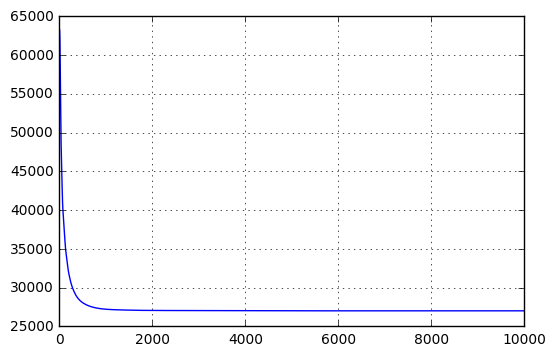

In [42]:
plt.plot(J_history)
plt.grid('on')
plt.show()

## Top 10 movie recommendation to me

In [43]:
X_result = X_Theta_new[0: num_movies * num_features].reshape(num_movies, -1)
Theta_result = X_Theta_new[num_movies * num_features: ].reshape(num_users, -1)
p = X_result.dot(Theta_result.T)
my_prediction = p[:, -1] + Y_mean
my_movies = pd.DataFrame({"score": my_prediction, "movie": list(movie_idx.values()), "original_rating": my_ratings.flatten()})
my_movies.sort_values(by='score', ascending=False).head(10)

,movie,original_rating,score
740,"Last Supper, The (1995)",0.0,5.328461
180,Return of the Jedi (1983),0.0,5.225146
49,Star Wars (1977),0.0,5.107370
425,"Transformers: The Movie, The (1986)",0.0,5.071293
171,"Empire Strikes Back, The (1980)",0.0,5.023790
100,Heavy Metal (1981),0.0,4.995106
874,She's So Lovely (1997),0.0,4.970150
1482,"Man in the Iron Mask, The (1998)",0.0,4.884855
623,"Three Caballeros, The (1945)",0.0,4.869497
836,Meet John Doe (1941),0.0,4.868569
